# Notebook to generate final plots
## <a id="Plots_index">Plots index:</a>
- [Observed Hours Example](#Observed_Hours)
- [Some Observed Hours Results](#Some_Observed_Hours_Results)
- [Some Hexbin Density Histograms](#Some_Hexbin)
- [Scatter Metrics for Model Outputs](#Scatter_Metrics_for_Model_Outputs)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Bar Charts Averaging Metrics over Stations](#Bar_Charts_Averaging_Metrics_over_Stations)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Bar Charts Averaging Metrics over Hours](#Bar_Charts_Averaging_Metrics_over_Hours)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Scatter Plots of 24h Error Graphics](#Scatter_Plots_of_24h_Error_Graphics)
  - Max, Average
- [Bar Charts of 24h Errors over Stations](#Bar_Charts_of_24h_Errors_over_Stations)
  - Max, Average
- [Results_df Table](#Results_df_Table)
- [Histogram Fit](#Histogram_Fit)
- [Overall Results Table](#Overall_Results_Table)


In [1]:
# Variable params
string_test = "4paper_test01_15x3_5btsp_24ph_v20"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9
meteo_vars = True

In [2]:
# Fixed params for notebook:
#
# Check additional configuration data (get_makeprediction_config,...)
# in conf/TrainingUserConfiguration.py

# for copy training_results_folder  from training notebook
training_results_folder = '/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019'
INPUT_SIZE = 3450 #copy(config[ModelParams.INPUT_SIZE])

In [3]:
import os
import pickle
import sys
import time
from datetime import date, datetime, timedelta
from copy import copy, deepcopy
from os import listdir

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib.colors import LogNorm
from pandas import DataFrame
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from AI.data_generation.utilsDataFormat import *
from ai_common.constants.AI_params import *
#from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams
from conf.TrainingUserConfiguration import getTrainingParams, get_makeprediction_config
from conf.localConstants import constants
from conf.params import LocalTrainingParams, PreprocParams
from os.path import join
from proj_io.inout import create_folder, add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData, loadScaler, extract_model_name
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca
from viz.figure_generator import plot_input_output_data


# Filtering warnings:
import warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING and INFO, 3 = filter out ERROR, WARNING, and INFO



In [4]:
# In case we want to save the columns to temporal files for debugging purposes
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')

create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)


# Evaluation

In [6]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
3450


In [7]:
# In case we want to save the columns to temporal files for debugging purposes
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # If there is no cuda available usually not needed on this notebook

config = get_makeprediction_config()

# *********** Read parameters ***********
input_file = config[ClassificationParams.input_file]
output_folder = f'{config[ClassificationParams.output_folder]}'
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

# Small set of stations, hours to evalaute some cases 
evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2019
# file with testing dataset with test_year
hardcoded_input_file = f'/ZION/AirPollutionData/Data/MergedDataCSV/16/{test_year}_AllStations.csv'

# %%
# cur_station fixed value to get statistics for bootstrapping
cur_station = 'MER'

# %% Para arreglar variables hardcodeadas:
# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)


# path to normalization data stored
norm_folder = join(training_results_folder,'norm')
imgs_folder = training_results_folder
path_csvs = training_results_folder

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")

print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestsPS_4paper_otres_2023_11_14_01_33
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
model_name:TestsPS_4paper_otres_2023_11_14_01_33
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestOZ
output_file_name:/ZION/AirPollutionData/TrainingTESTOZ/Results/TestOZ.csv
model_weights_file:/ZION/AirPollutionData/TrainingTESTOZ/models
forecasted_hours:24
pollutant:otres



In [8]:
# %% Definitions of folders where images and data will be exported

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [9]:
model_name_user = config[TrainingParams.config_name]
print(model_name_user)
print(output_folder)

TestOZ
/ZION/AirPollutionData/Data/Results


In [10]:
#%% Loading the best weight file on the weights folder
path_model_weights = join(f'{training_results_folder}',f'models')
print(path_model_weights)

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(lista_weights)
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
assert len(model_weights_file) > 0
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)

/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models
[0.6035378, 0.56642407, 0.5302577, 0.43525407, 0.36179197, 0.32665047, 0.31272238, 0.30621785, 0.30049142, 0.29688501, 0.29235762, 0.28878742, 0.28336212, 0.28049308, 0.27818382, 0.27597681, 0.27464828, 0.2721507, 0.27201834, 0.26983255, 0.26947716, 0.26739654, 0.26627365, 0.2655074, 0.26438257, 0.26381394, 0.26331496, 0.26196802, 0.26072904, 0.26069912, 0.26004851, 0.25991949, 0.25848687, 0.25844783]

Model weight file to use of    0.25844783: 

 /ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models/TestsPS_4paper_otres_2023_11_14_01_33-epoch-41-loss-0.25844783.hdf5


In [11]:
#%% data test file
input_file = hardcoded_input_file
assert len(input_file) > 0
data = pd.read_csv(input_file, index_col=0)

In [12]:
# Remove meteo ?
import re
if not meteo_vars:
    regex_list = ['U10.*', 'V10.*','RAINC.*', 'T2.*', 'RAINNC.*', 'SWDOWN.*', 'GLW.*']
    filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
    print(filtered_data)
    data = filtered_data


In [13]:
#%% Redo the test dataset data as in the hot vectors used during training.

datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [14]:
# %% -------- Normalizing data
# loading of original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)


In [15]:
# %% compiling a scale according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
#print(old_features)


In [16]:
# %%
prefijo = 'plusfake_x_' #dummy prefix hack
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [17]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)
#print(data_norm_df)

Normalizing data....


In [18]:
#%% Continuing to get the input vector format

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

# %% ====== Remove columns for other pollutants

cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')


# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)
# Vamos conservar los nan de Y_df en este caso
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8761, 2730), Memory usage: 182.543114 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (8761, 3450), Memory usage: 230.668724 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8761, 720)
Done!
Done!
Original (8761, 2925)
X (8737, 3450), Memory usage: 230.036827 MB
Y (8737, 720), Memory usage: 48.060432 MB
Removing time index...
Replacing nan values with 0...


In [19]:
# %% Visualize input and outputs

#print("Visualizing input and outputs...")
#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


In [20]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Calculo de predicciones de el dataset de test:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Desescalar de predicciones y y_true, y su procesado
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)
#print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)

#print(y_true_df.head())

# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]




Reading model ....
Reading weights ....


## <a id="Observed_Hours">Observed Hours Example</a>
- [Return to Plots Index](#Plots_index)  

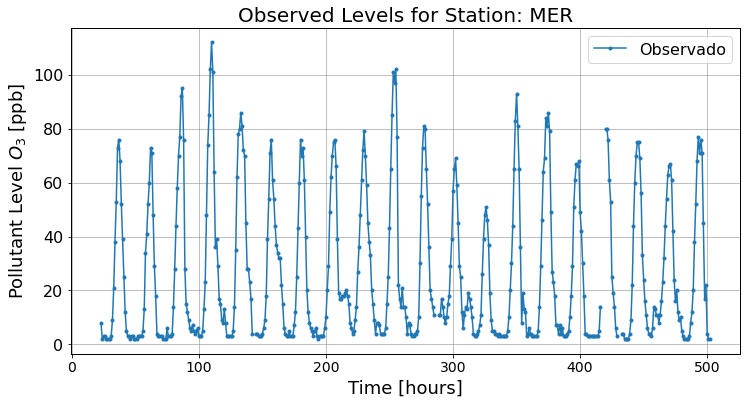

In [21]:
import matplotlib.pyplot as plt

def plot_simple(x_plot, y_true_column, title='Gráfica Simple', x_label='Eje X', y_label='Eje Y'):
    """
    Genera una gráfica simple de los datos proporcionados.

    Parámetros:
    x_data (iterable): Datos para el eje X.
    y_data (iterable): Datos para el eje Y.
    title (str): Título de la gráfica.
    x_label (str): Etiqueta para el eje X.
    y_label (str): Etiqueta para el eje Y.
    """
    plot_this_many = 24 * 20  # Number of points to plot

    plt.close('all')
    fig, ax = plt.subplots(figsize=[12, 6])

    ax.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observado')

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.set_title(title, fontsize=20)

    # Configurar la cuadrícula
    ax.grid(True, color='grey', linestyle='-', linewidth=0.5)

    # Configurar los bordes (spines) de la gráfica
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.)

    ax.legend(fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    plt.show()

# Use example of observed Hours for introduction sections

y_true_column = y_true_df['plus_01_cont_otres_MER']
x_plot  = range(23, 23 + len(y_true_column))

# plot_simple(x_plot, y_true_column, title='Niveles Observados para la Estación: MER', x_label='Tiempo [horas]', y_label='Nivel de Contaminante $O_3$ [ppb]')
plot_simple(x_plot, y_true_column, title='Observed Levels for Station: MER', x_label='Time [hours]', y_label='Pollutant Level $O_3$ [ppb]')


In [22]:
#print(y_true_df)
#print(y_pred_descaled_df)

In [23]:
#y_true_df.to_csv('./)

## <a id="Some_Observed_Hours_Results">Some Observed Hours Results</a>
- [Return to Plots Index](#Plots_index)  

plus_01_cont_otres_UIZ


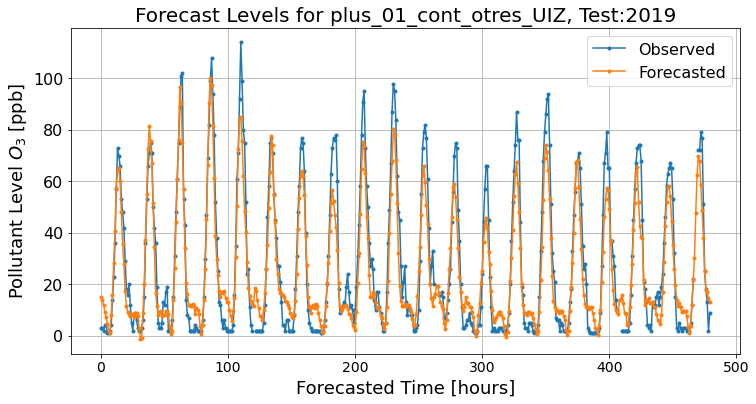

plus_06_cont_otres_UIZ


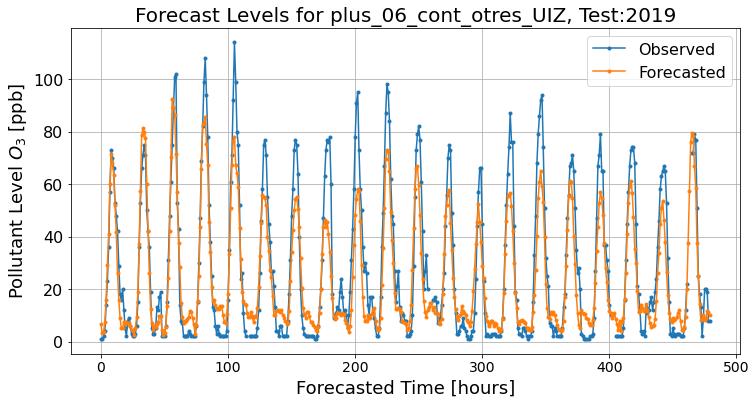

plus_12_cont_otres_UIZ


plus_18_cont_otres_UIZ


plus_24_cont_otres_UIZ


plus_01_cont_otres_AJU


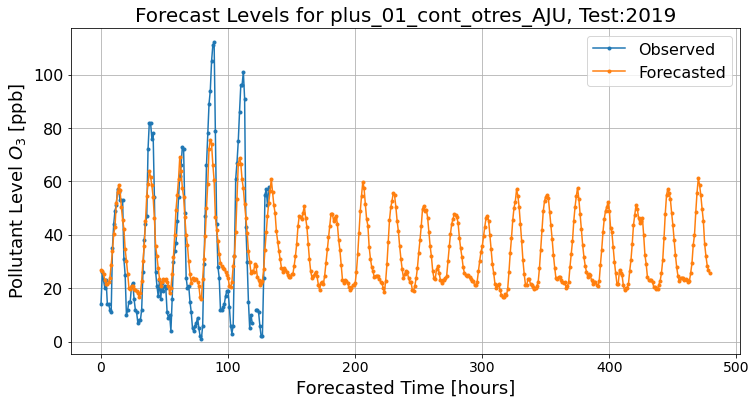

plus_06_cont_otres_AJU


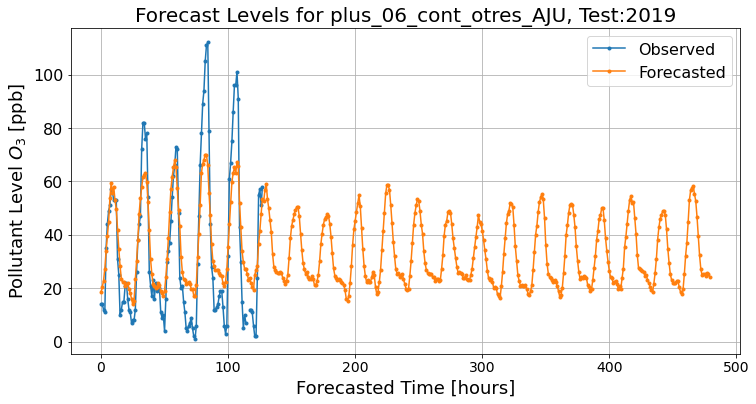

plus_12_cont_otres_AJU


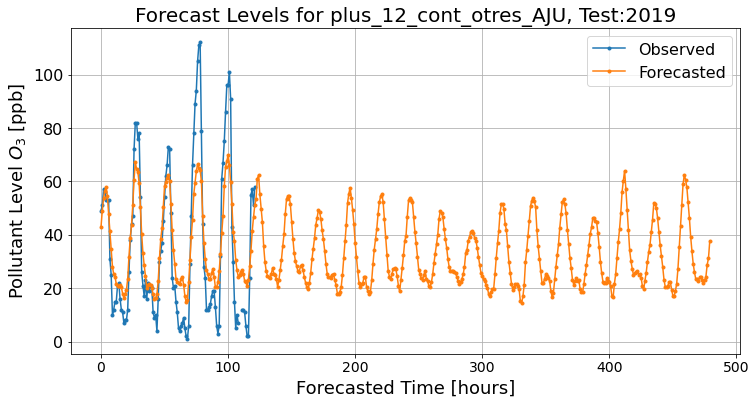

plus_18_cont_otres_AJU


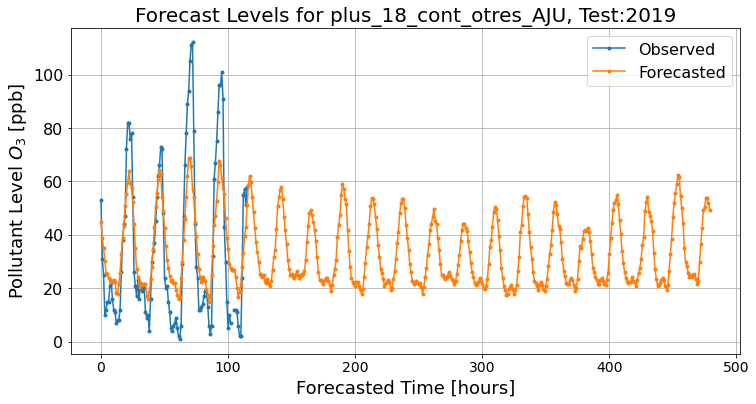

plus_24_cont_otres_AJU


plus_01_cont_otres_ATI


plus_06_cont_otres_ATI


plus_12_cont_otres_ATI


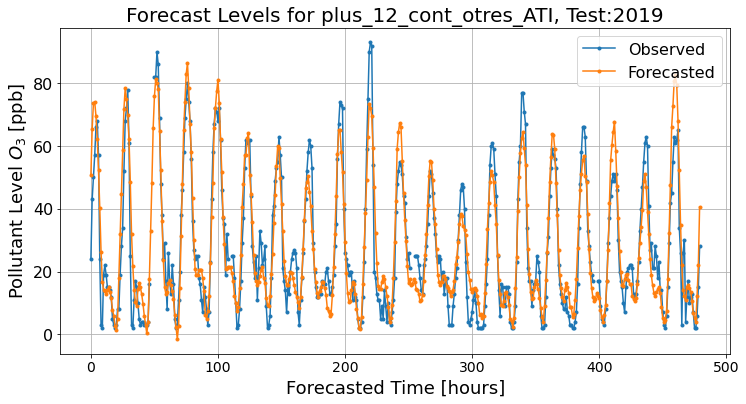

plus_18_cont_otres_ATI


plus_24_cont_otres_ATI


plus_01_cont_otres_UAX


plus_06_cont_otres_UAX


plus_12_cont_otres_UAX


plus_18_cont_otres_UAX


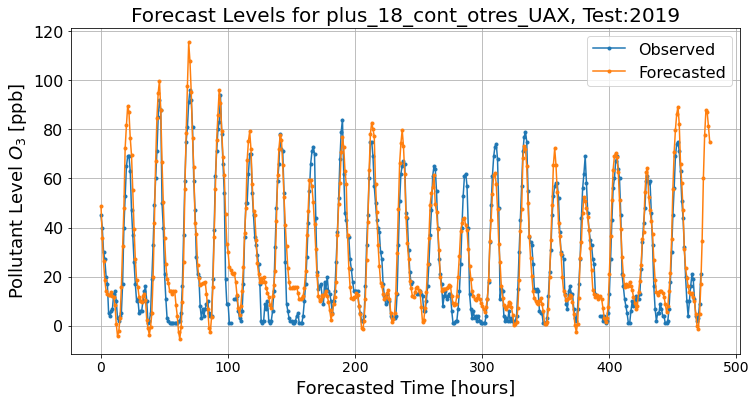

plus_24_cont_otres_UAX


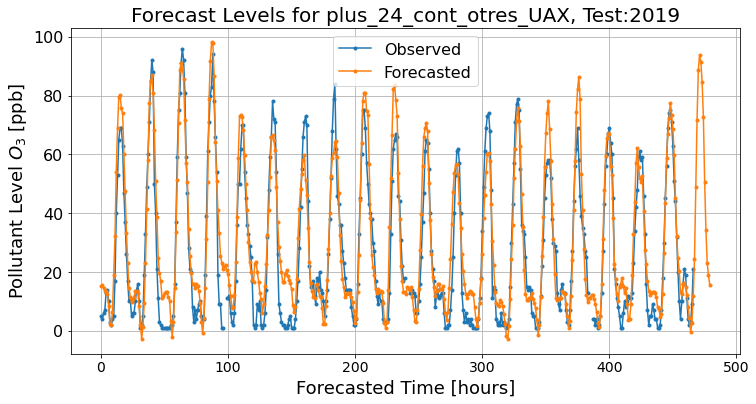

In [24]:
import matplotlib.pyplot as plt
from os.path import join

def plot_forecast_hours(column_to_plot, y_true_df, y_pred_descaled_df, 
                        output_results_folder_img=None, show_grid=True, 
                        x_label='Forecasted Time [hours]', y_label='Pollutant Level $O_3$ [ppb]', 
                        title_str=None, save_fig=True):
    """
    Generate a plot for forecast hours.

    Parameters:
    ...
    """
    plt.close('all')
    plot_this_many = 24 * 20  # Number of points to plot
    
    # Retrieve columns for plotting
    y_true_column = y_true_df[column_to_plot]
    y_pred_column = y_pred_descaled_df[column_to_plot]
    
    x_plot = range(len(y_true_column))
    
    # Plotting
    plt.figure(figsize=[12, 6])
    
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    
    plt.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observed')
    plt.plot(x_plot[0:plot_this_many], y_pred_column[0:plot_this_many], marker='.', label='Forecasted')
    
    if title_str is not None:
        plt.title(title_str, fontsize=20)
    else:
        plt.title(f'Forecast Levels for {column_to_plot}', fontsize=20)
        
    if show_grid:
        plt.grid(True)
    
    plt.legend(fontsize=16)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=16)
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'hours_plot_{column_to_plot.lower()}.png'), dpi=300)
    
    plt.show()

# Ploting forecast and observed hours on dataset

plt.close('all')

for cur_column in params_grid:
    print(cur_column)
    
    # Llamar a la función con la columna deseada y argumentos adicionales
    plot_forecast_hours(
        cur_column, 
        y_true_df, 
        y_pred_descaled_df, 
        output_results_folder_img=output_results_folder_img,
        show_grid=True, 
        x_label='Forecasted Time [hours]', 
        y_label='Pollutant Level $O_3$ [ppb]',
        title_str=f'Forecast Levels for {cur_column}, Test:2019',
        save_fig=True
    )


## <a id="Some_Hexbin">Some Hexbin Density Histograms</a>
- [Return to Plots Index](#Plots_index)  

column name:plus_01_cont_otres_UIZ
Correlation index:                     0.9362


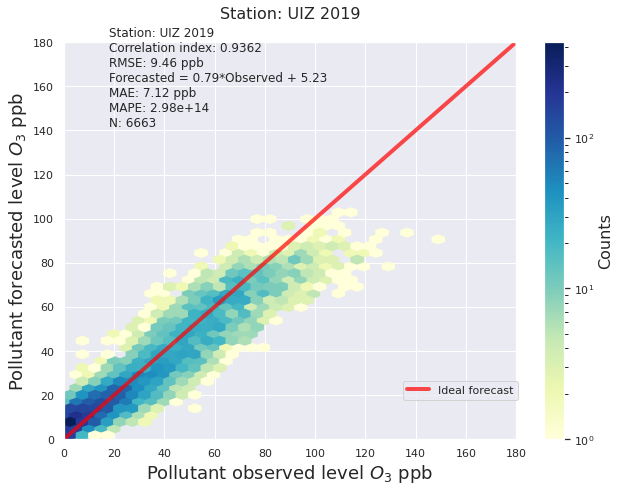

column name:plus_06_cont_otres_UIZ
Correlation index:                     0.8914


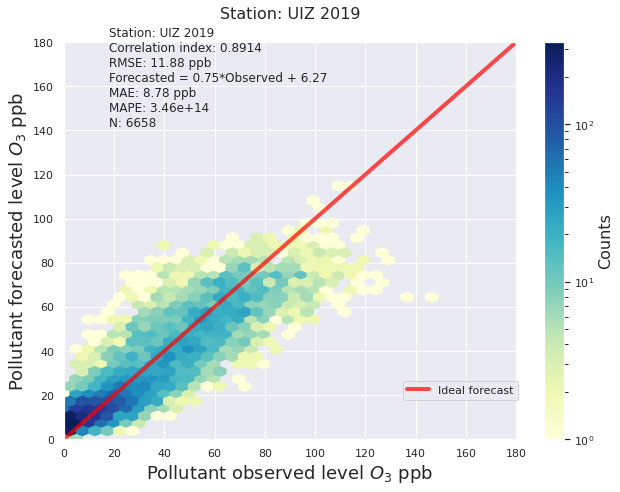

column name:plus_12_cont_otres_UIZ
Correlation index:                     0.8959


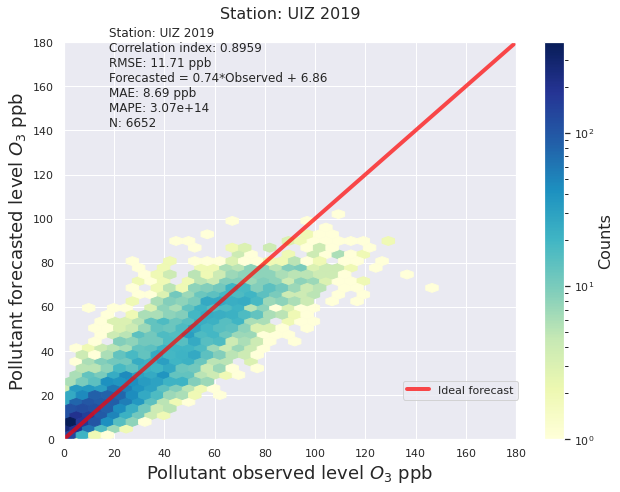

column name:plus_18_cont_otres_UIZ
Correlation index:                     0.8953


column name:plus_24_cont_otres_UIZ
Correlation index:                     0.8828


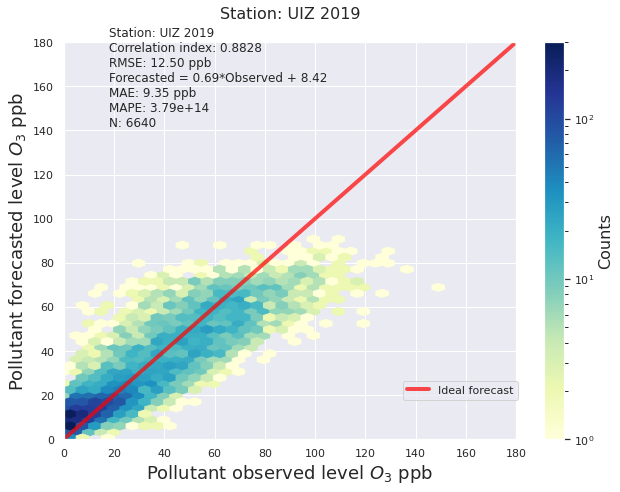

column name:plus_01_cont_otres_AJU
Correlation index:                     0.8932


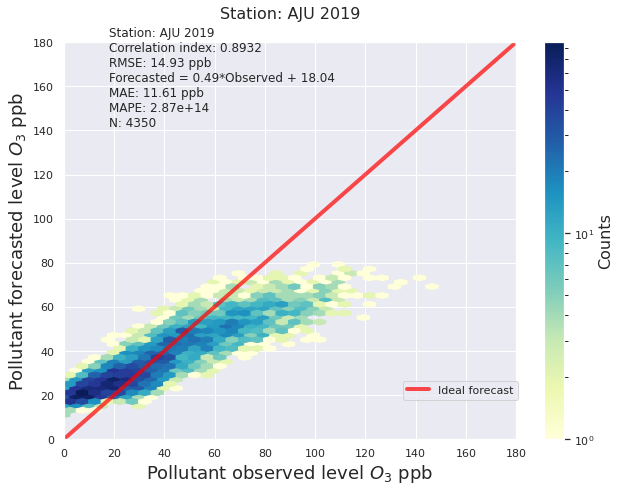

column name:plus_06_cont_otres_AJU
Correlation index:                     0.8628


column name:plus_12_cont_otres_AJU
Correlation index:                     0.8603


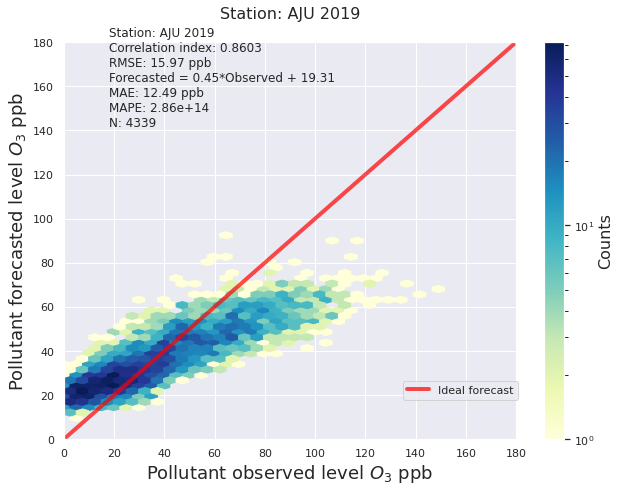

column name:plus_18_cont_otres_AJU
Correlation index:                     0.8583


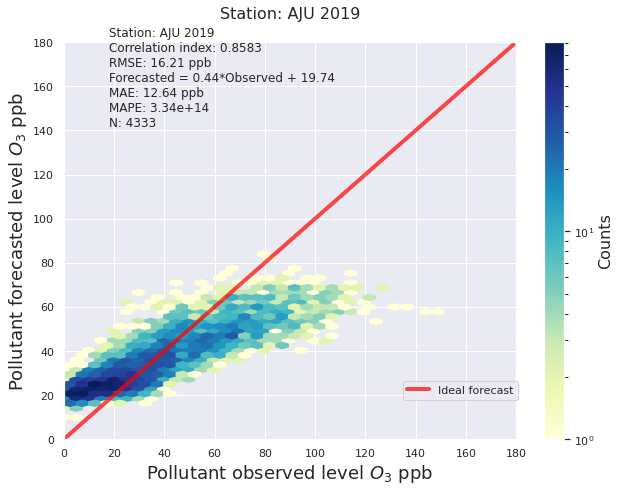

column name:plus_24_cont_otres_AJU
Correlation index:                     0.8414


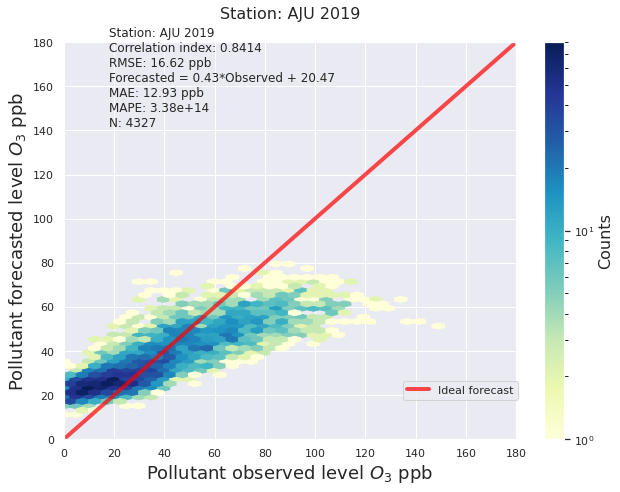

column name:plus_01_cont_otres_ATI
Correlation index:                     0.9282


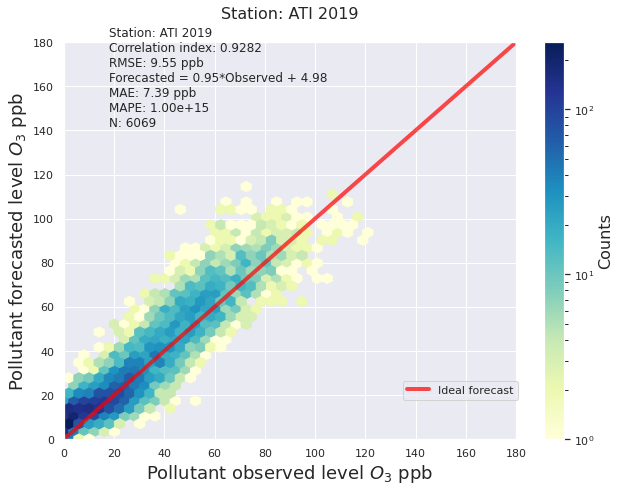

column name:plus_06_cont_otres_ATI
Correlation index:                     0.8853


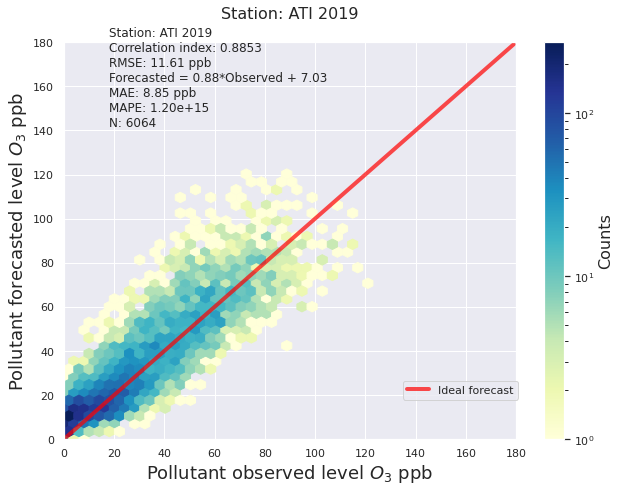

column name:plus_12_cont_otres_ATI
Correlation index:                     0.8811


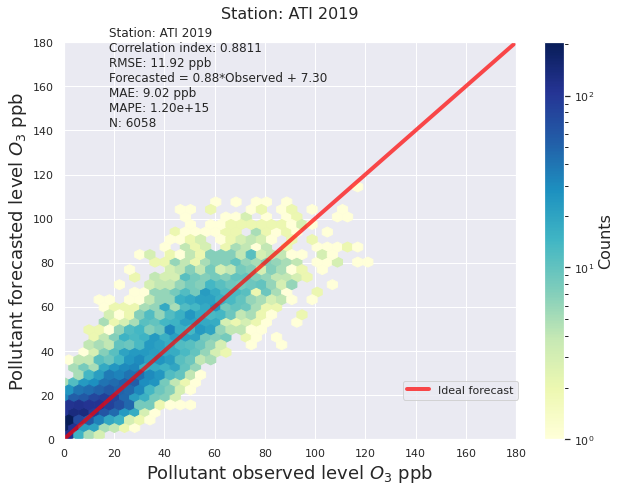

column name:plus_18_cont_otres_ATI
Correlation index:                     0.8803


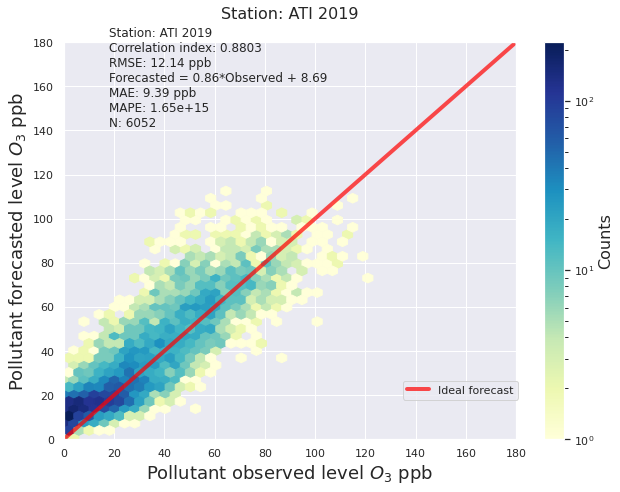

column name:plus_24_cont_otres_ATI
Correlation index:                     0.8796


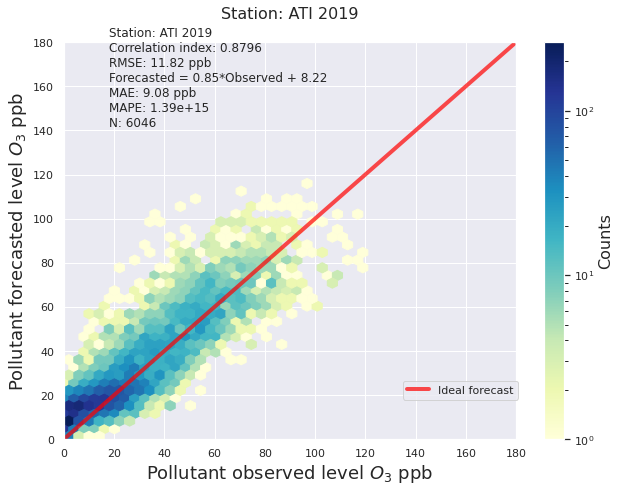

column name:plus_01_cont_otres_UAX
Correlation index:                     0.9091


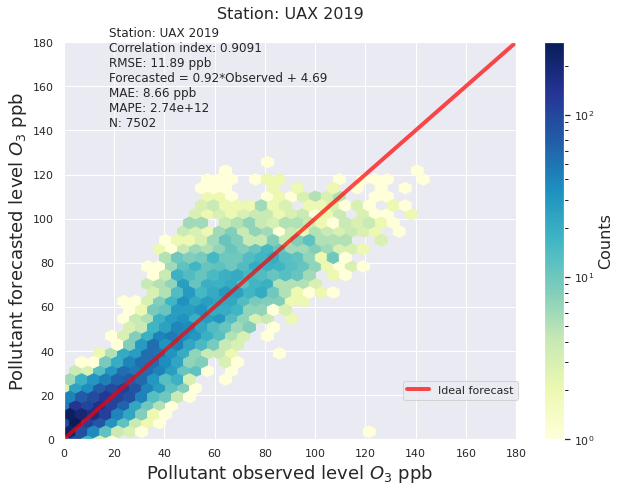

column name:plus_06_cont_otres_UAX
Correlation index:                     0.8794


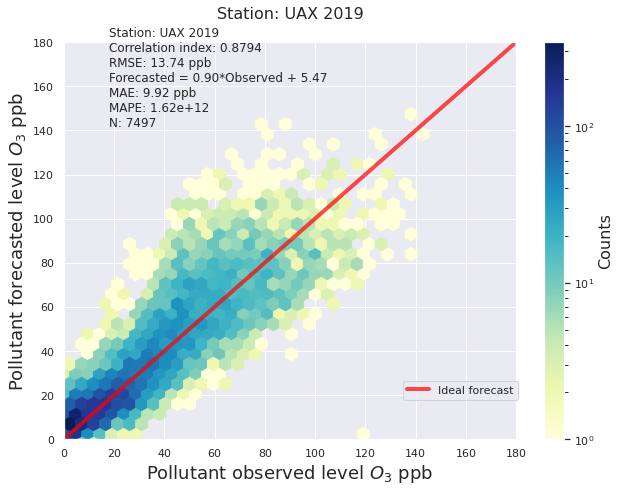

column name:plus_12_cont_otres_UAX
Correlation index:                     0.8735


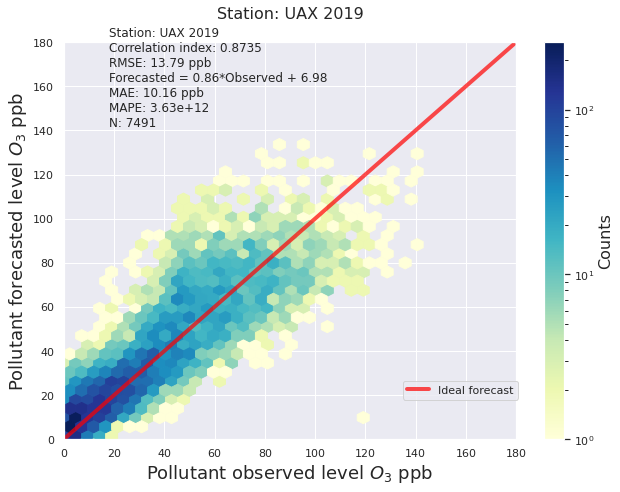

column name:plus_18_cont_otres_UAX
Correlation index:                     0.8719


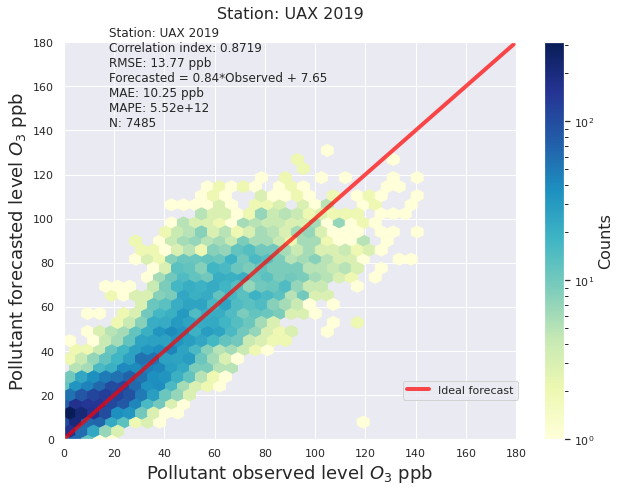

column name:plus_24_cont_otres_UAX
Correlation index:                     0.8636


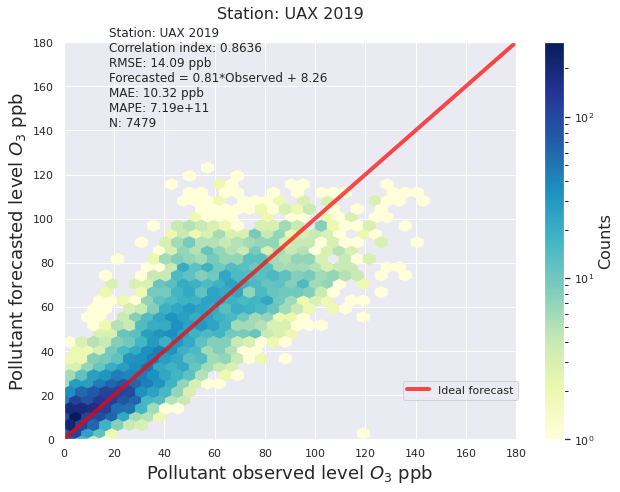

In [25]:
# %% Evaluating only a set of stations and hours
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

# Visualize evolution of n_hours forecasted
#for station in evaluate_stations:
#    analyze_multi_hour_plot(
#        station,
#       evaluate_hours,
#        y_pred_descaled_df,
#        y_true_df,
#        test_year=test_year,
#       output_results_folder_img=output_results_folder_img)


In [26]:
# %% #Create DataFrame with metric results 

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2","Index of agreement"
])

for cur_column in y_pred_descaled_df.columns:
    #print(cur_column)
    column_results = analyze_column(cur_column,
                                    y_pred_descaled_df,
                                    y_true_df,
                                    test_year=test_year,
                                    generate_plot=False)
    results_df = results_df.append(column_results, ignore_index=True)




Correlation index:                     0.9362
Correlation index:                     0.8932
Correlation index:                     0.9282
Correlation index:                     0.8837
Correlation index:                     0.9043
Correlation index:                     0.9355
Correlation index:                     0.9398
Correlation index:                     0.9400
Correlation index:                     0.9195
Correlation index:                     0.9313
Correlation index:                     0.9461
Correlation index:                     0.9378
Correlation index:                     0.9437
Correlation index:                     0.9038
Correlation index:                     0.9351
Correlation index:                     0.9443
Correlation index:                     0.9328
Correlation index:                     0.9399
Correlation index:                     0.9479
Correlation index:                     0.9250
Correlation index:                     0.9357
Correlation index:                

Correlation index:                     0.9000
Correlation index:                     0.8951
Correlation index:                     0.8801
Correlation index:                     0.8864
Correlation index:                     0.8381
Correlation index:                     0.8924
Correlation index:                     0.8890
Correlation index:                     0.8063
Correlation index:                     0.8291
Correlation index:                     0.8588
Correlation index:                     0.8891
Correlation index:                     0.8623
Correlation index:                     0.8847
Correlation index:                     0.8159
Correlation index:                     0.8426
Correlation index:                     0.9024
Correlation index:                     0.9100
Correlation index:                     0.8820
Correlation index:                     0.8768
Correlation index:                     0.8920
Correlation index:                     0.8990
Correlation index:                

Correlation index:                     0.8637
Correlation index:                     0.8811
Correlation index:                     0.8937
Correlation index:                     0.8738
Correlation index:                     0.8867
Correlation index:                     0.8961
Correlation index:                     0.8863
Correlation index:                     0.8965
Correlation index:                     0.8906
Correlation index:                     0.8715
Correlation index:                     0.8819
Correlation index:                     0.8273
Correlation index:                     0.8925
Correlation index:                     0.8908
Correlation index:                     0.7924
Correlation index:                     0.8304
Correlation index:                     0.8575
Correlation index:                     0.8944
Correlation index:                     0.8579
Correlation index:                     0.8775
Correlation index:                     0.8113
Correlation index:                

Correlation index:                     0.9002
Correlation index:                     0.8854
Correlation index:                     0.8962
Correlation index:                     0.8600
Correlation index:                     0.8817
Correlation index:                     0.8875
Correlation index:                     0.8742
Correlation index:                     0.8940
Correlation index:                     0.8909
Correlation index:                     0.8853
Correlation index:                     0.8998
Correlation index:                     0.8986
Correlation index:                     0.8722
Correlation index:                     0.8778
Correlation index:                     0.8176
Correlation index:                     0.8947
Correlation index:                     0.8893
Correlation index:                     0.7862
Correlation index:                     0.8240
Correlation index:                     0.8739
Correlation index:                     0.8892
Correlation index:                

In [27]:
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ',
       'INN', 'AJM', 'VIF'], dtype=object)

In [28]:
results_df.rename(columns={'Índice de correlación': 'Correlation Index'}, inplace=True)


In [29]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.936156   7.118227  2.976779e+14   
1    plus_01_cont_otres_AJU           0.893209  11.612323  2.873532e+14   
2    plus_01_cont_otres_ATI           0.928181   7.391601  1.003184e+15   
3    plus_01_cont_otres_CUA           0.883675   8.394414  3.908166e-01   
4    plus_01_cont_otres_SFE           0.904346   8.120199  1.434481e+14   
..                      ...                ...        ...           ...   
715  plus_24_cont_otres_MON           0.890021   9.995342  6.066160e+12   
716  plus_24_cont_otres_NEZ           0.886378  10.266807  9.246081e+12   
717  plus_24_cont_otres_INN           0.778344  10.772329  4.597497e-01   
718  plus_24_cont_otres_AJM           0.811592  11.239305  6.257708e-01   
719  plus_24_cont_otres_VIF           0.875941   8.352417  6.331904e-01   

            MSE       RMSE        R2  Index of agreement  
0     89.398051   9.455054  0.868104            0.960310  
1    222.984055  14.932651  0.673850            0.857260  
2     91.249598   9.552466  0.828155            0.956939  
3    120.091363  10.958620  0.771604            0.935130  
4    111.815082  10.574265  0.799840            0.945033  
..          ...        ...       ...                 ...  
715  153.231393  12.378667  0.778858            0.926966  
716  186.022384  13.639002  0.754519            0.916757  
717  179.691898  13.404921  0.575893            0.827604  
718  205.260524  14.326916  0.630920            0.878210  
719  117.888613  10.857652  0.761329            0.922356  

[720 rows x 8 columns]

## <a id="Scatter_Metrics_for_Model_Outputs">Scatter Metrics for Model Outputs</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Plots index return](#Plots_index)

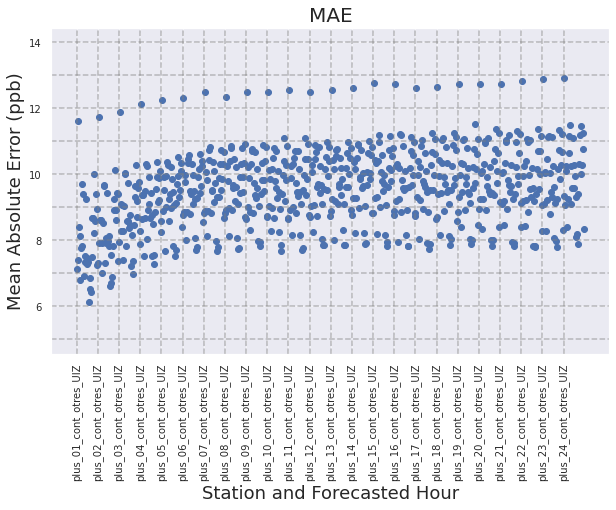

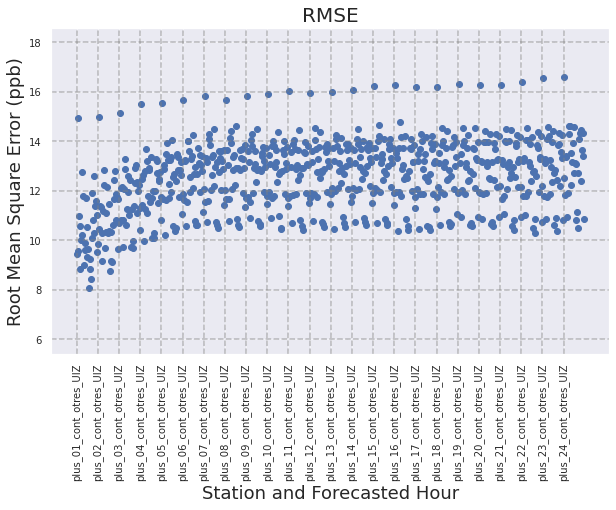

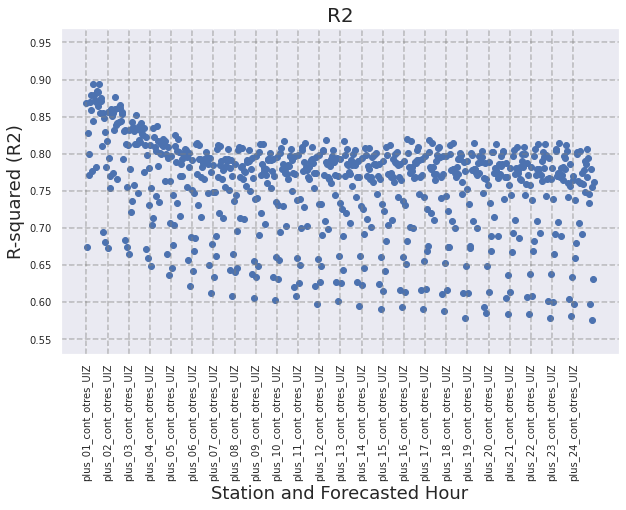

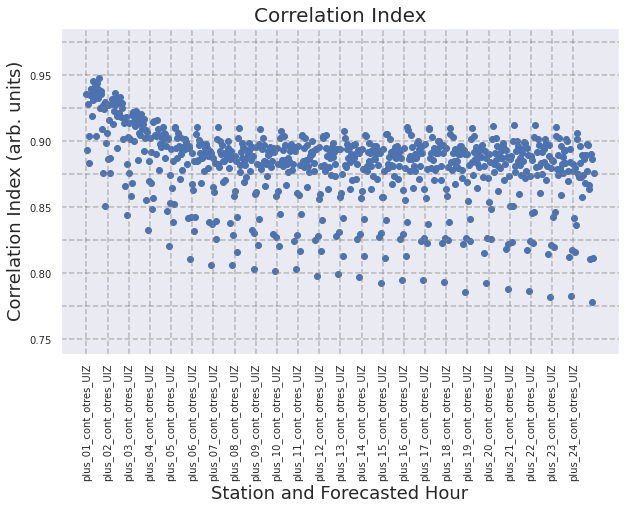

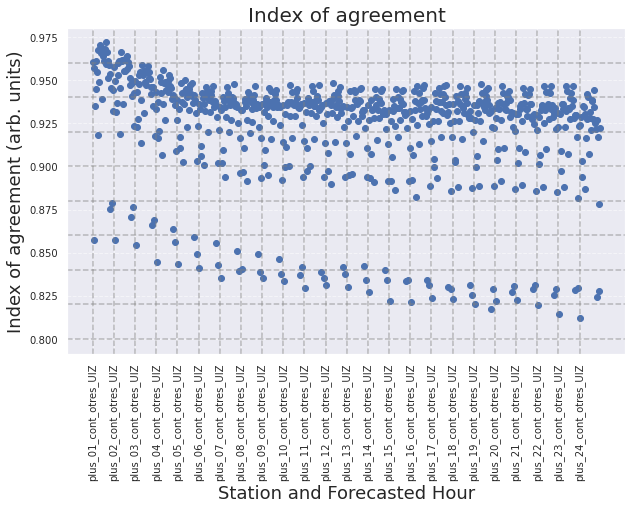

In [30]:
from os.path import join
import matplotlib.pyplot as plt

def scatter_plot_by_column(df, metric, output_folder=None, 
                           show_grid=True, x_label='Station and forecasted hours', 
                           y_label=None, title_str=True, save_fig=True,
                           x_label_fontsize=18, y_label_fontsize=18, 
                           title_fontsize=20, tick_fontsize=14):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[metric])
    
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label if y_label else metric, fontsize=y_label_fontsize)
    
    if title_str:
        title_str = f'{metric}'
    else:
        title_str = ''
        
    plt.title(title_str, fontsize=title_fontsize)
    
    x_ticks = df.index[::30]
    x_labels = df['Columna'][::30]
    plt.xticks(x_ticks, x_labels, rotation=90, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    if show_grid:
        for x in x_ticks:
            plt.axvline(x, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='x', linestyle='dashed', alpha=0.5)
        
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    if save_fig and output_folder:
        plt.savefig(join(output_folder, f'scatter_plot_{metric.lower()}.png'), dpi=300)
        
    plt.show()
# Para MAE
scatter_plot_by_column(results_df, 'MAE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Mean Absolute Error (ppb)', 
                title_str='Mean Absolute Error Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para RMSE
scatter_plot_by_column(results_df, 'RMSE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Root Mean Square Error (ppb)', 
                title_str='Root Mean Square Error Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para R2
scatter_plot_by_column(results_df, 'R2',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='R-squared (R2)', 
                title_str='R-squared (R2) Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)
# CC
scatter_plot_by_column(results_df, 'Correlation Index',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Correlation Index (arb. units)', 
                title_str='Correlation Index Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)


# IoA
scatter_plot_by_column(results_df, 'Index of agreement',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Index of agreement (arb. units)', 
                title_str='Index of agreement Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

## <a id="Bar_Charts_Averaging_Metrics_over_Stations">Bar Charts Averaging Metrics over Stations</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index) 

Per station MAE: 9.5403


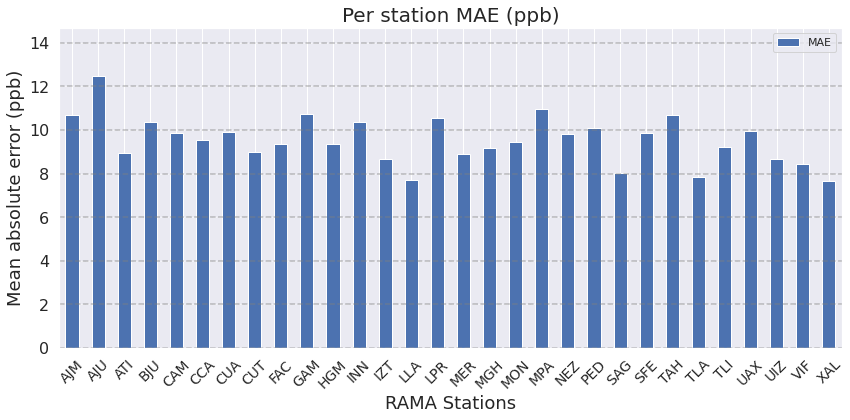

Per station RMSE: 12.5676


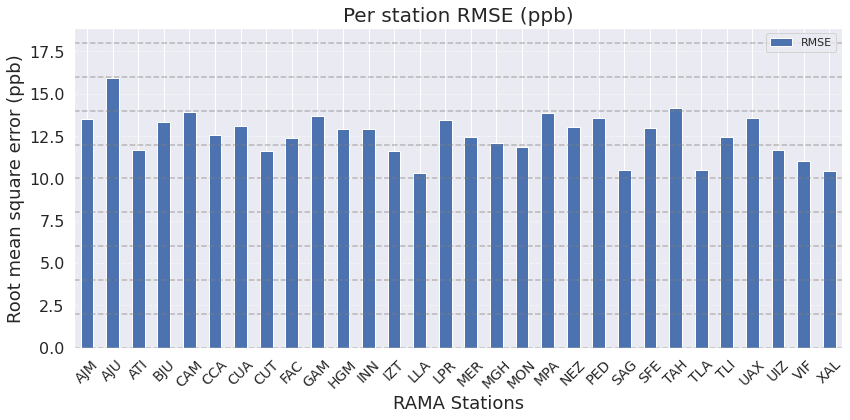

Per station R2: 0.7568


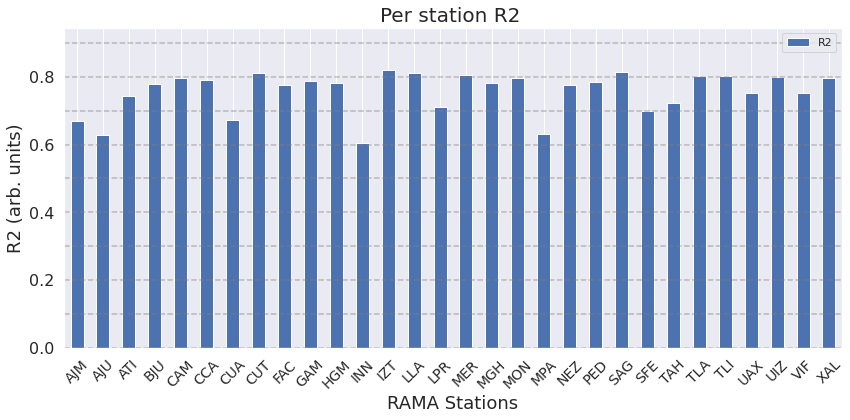

Per station Correlation Index: 0.8809


Per station Index of agreement: 0.9223


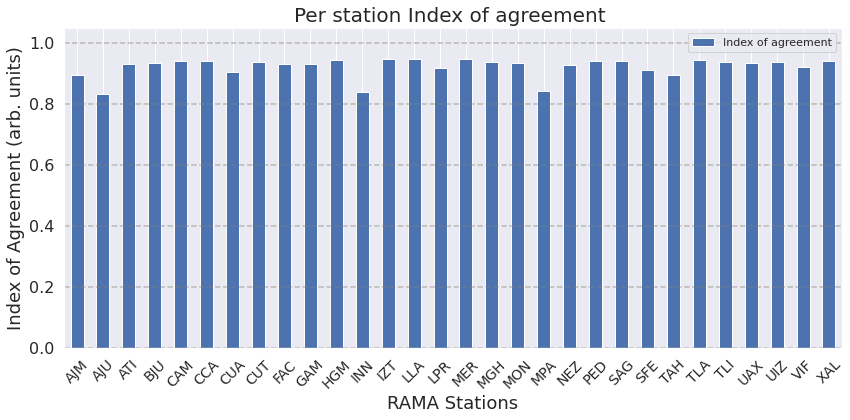

In [31]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric(results_df, metric, output_results_folder_img=None, 
                    show_grid=True, x_label='Station', y_label=None, 
                    title_suffix='', save_fig=True, title_str=True,
                    subtitle=True):
    """
    Generate a bar plot for average metrics.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics
    def calculate_average_metrics(df, key):
        return df[df['Columna'].str.endswith(key)][metric].mean()

    station_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[-1])))
    average_metrics = [calculate_average_metrics(results_df, key) for key in station_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: station_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Per station {metric}: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'Per station {metric} {title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall stations {metric} {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()  # Obtener los ticks del eje y
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)  # Agregar grid en el eje y
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_metric_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()


average_metric(results_df, 'MAE', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Mean absolute error (ppb)',title_str=True,title_suffix='(ppb)', save_fig=True,subtitle=False)
average_metric(results_df, 'RMSE', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Root mean square error (ppb)',title_str=True,title_suffix='(ppb)', save_fig=True,subtitle=False)
average_metric(results_df, 'R2', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='R2 (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Correlation index (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Index of Agreement (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)


## <a id="Bar_Charts_Averaging_Metrics_over_Hours">Bar Charts Averaging Metrics over Hours</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index)  

Overall average of MAE across all hours: 9.5403


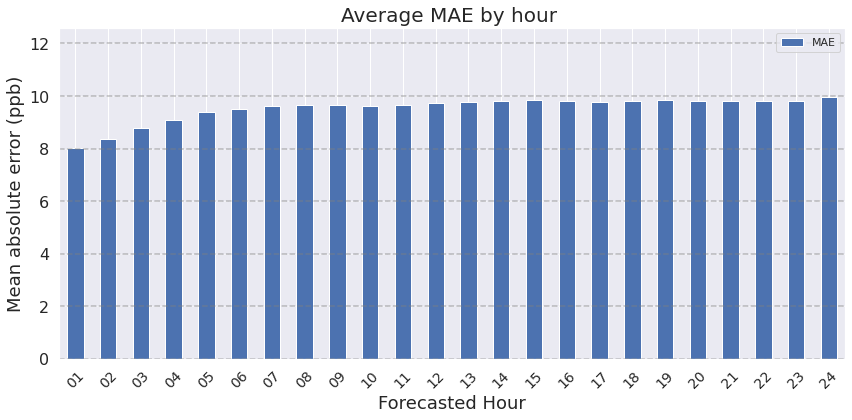

Overall average of RMSE across all hours: 12.5676


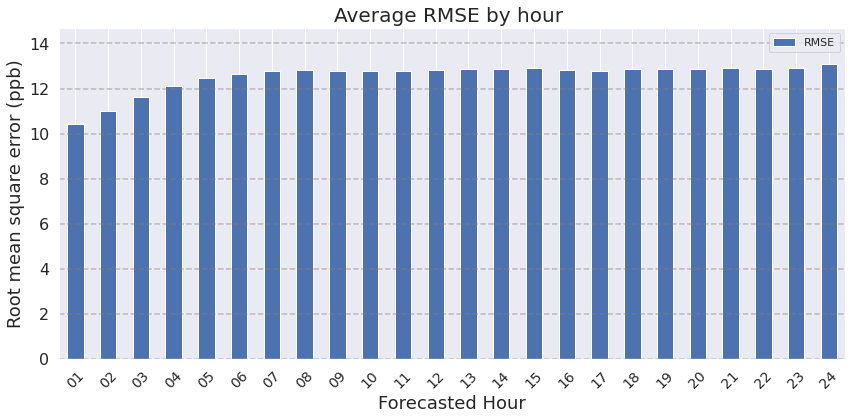

Overall average of R2 across all hours: 0.7568


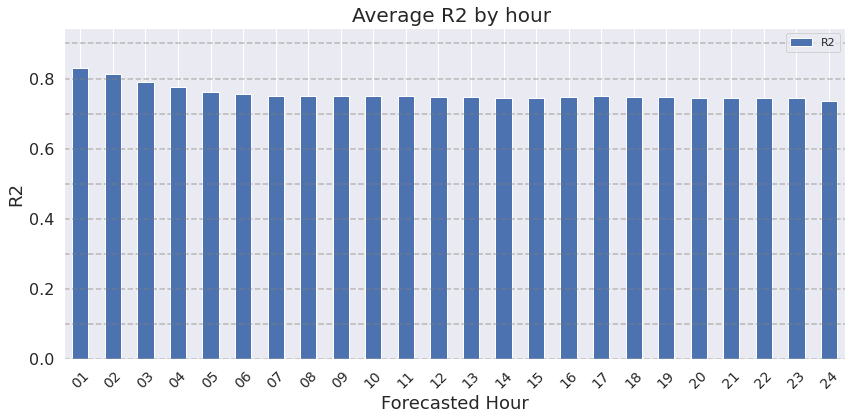

Overall average of Correlation Index across all hours: 0.8809


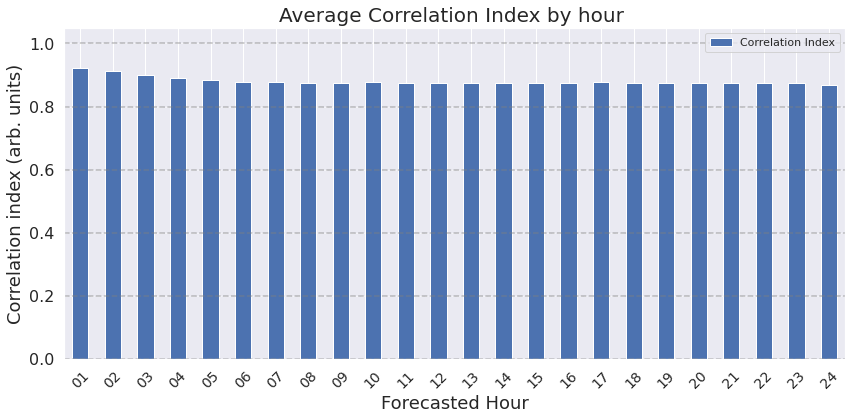

Overall average of Index of agreement across all hours: 0.9223


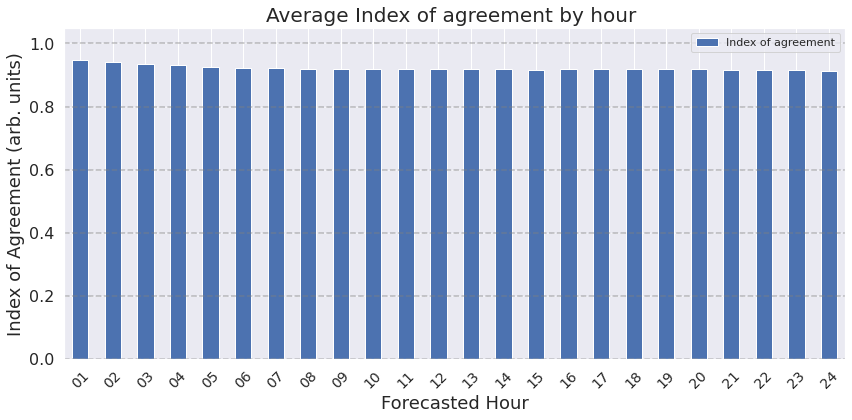

In [32]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric_by_hour(results_df, metric, output_results_folder_img=None, 
                           show_grid=True, x_label='Forecasted Hour', y_label=None, 
                           title_suffix='', save_fig=True, title_str=True, 
                           subtitle=True):
    """
    Generate a bar plot for average metrics by hour.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics by hour
    def calculate_average_metrics_by_hour(df, key):
        return df[df['Columna'].str.contains(key)][metric].mean()

    hour_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[1])), 
                       key=lambda x: int(x.split('plus_')[-1]))
    average_metrics = [calculate_average_metrics_by_hour(results_df, key) for key in hour_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: hour_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Overall average of {metric} across all hours: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'Average {metric} by hour {title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall average of {metric} across all hours: {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_hours_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()
# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'MAE', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Mean absolute error (ppb)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Root mean square error (ppb)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'R2', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='R2',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Correlation index (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Index of Agreement (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)


24h Errors

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.998422144227109
Desviación estándar de diferencia en valores máximos diarios: 12.42738826684824


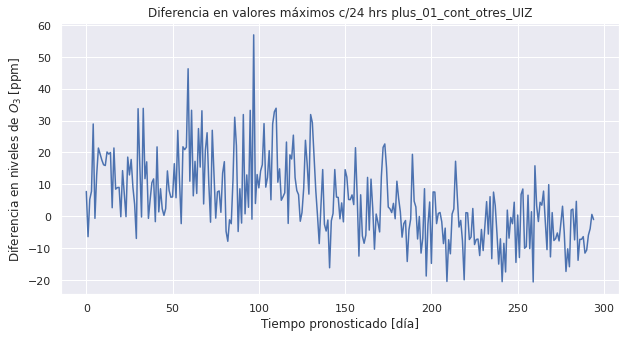

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.501271503254519
Desviación estándar de diferencia en valores máximos diarios: 17.058492970969926


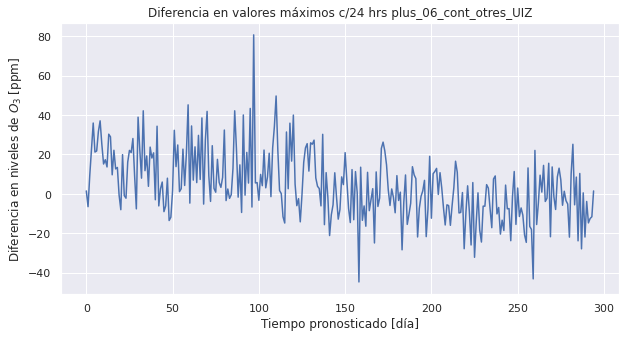

plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.398984526312072
Desviación estándar de diferencia en valores máximos diarios: 15.778194264323178


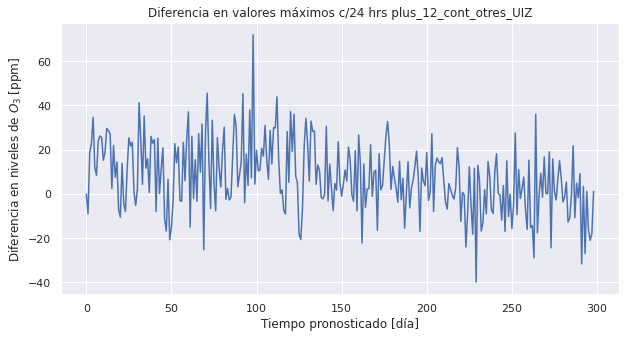

plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.192483982524356
Desviación estándar de diferencia en valores máximos diarios: 16.85538015229221


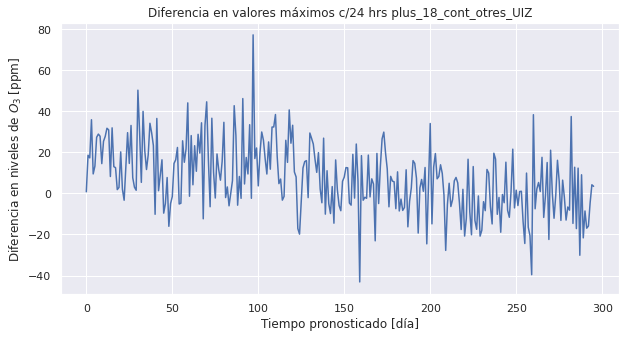

plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 8.10032563469037
Desviación estándar de diferencia en valores máximos diarios: 17.842632761683543


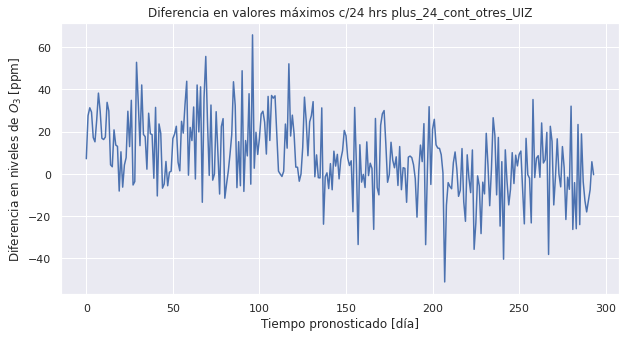

plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.586409340077395
Desviación estándar de diferencia en valores máximos diarios: 18.23452213721007


plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.268779479705536
Desviación estándar de diferencia en valores máximos diarios: 19.816406324176942


plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.61732495797647
Desviación estándar de diferencia en valores máximos diarios: 19.052380683108723


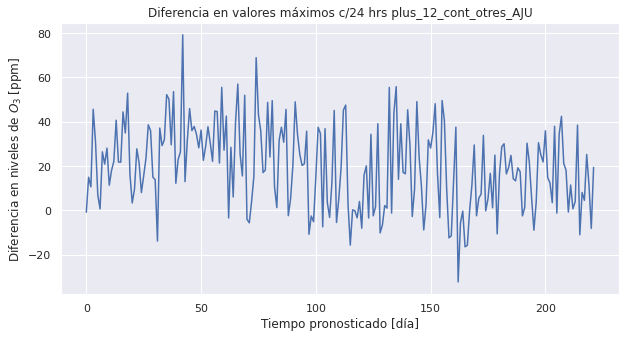

plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 20.05894964430067
Desviación estándar de diferencia en valores máximos diarios: 20.09875769826661


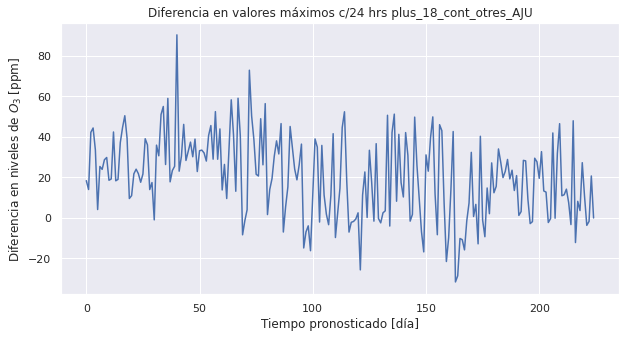

plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 18.786757011936135
Desviación estándar de diferencia en valores máximos diarios: 21.35682668352127


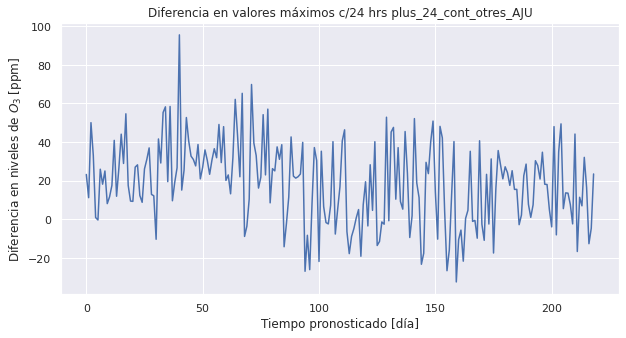

plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -5.129151033632683
Desviación estándar de diferencia en valores máximos diarios: 11.109957142069682


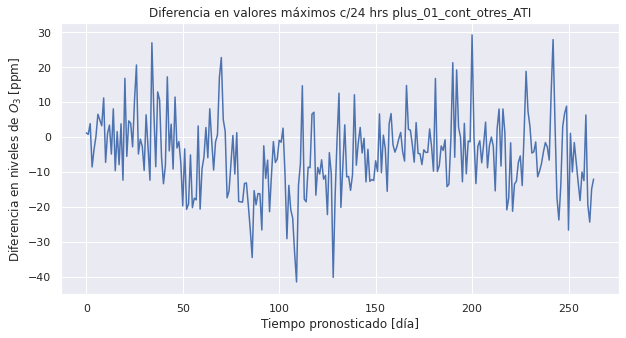

plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -4.700210137474806
Desviación estándar de diferencia en valores máximos diarios: 15.51406774336254


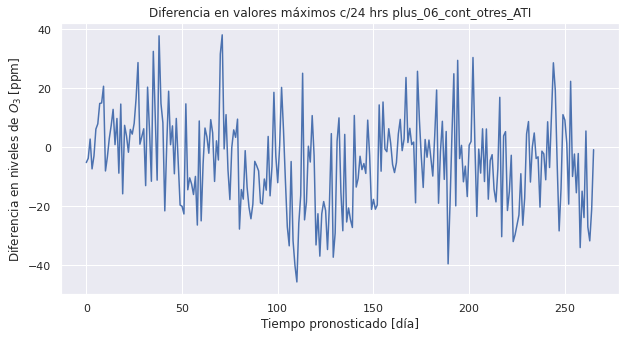

plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.320799583779242
Desviación estándar de diferencia en valores máximos diarios: 15.121605542026291


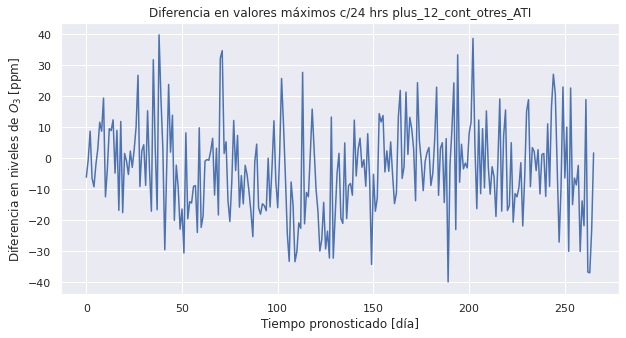

plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.8999148242878463
Desviación estándar de diferencia en valores máximos diarios: 14.736732184703273


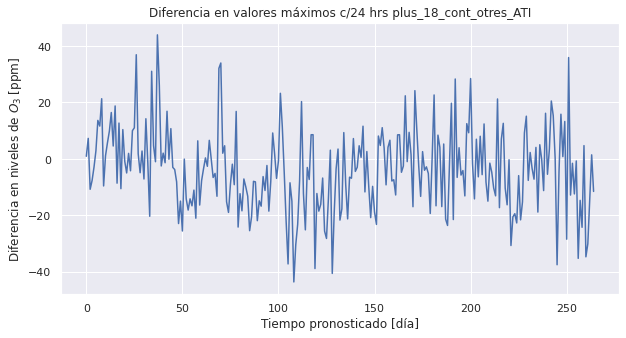

plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -3.532945388218142
Desviación estándar de diferencia en valores máximos diarios: 16.2954444506172


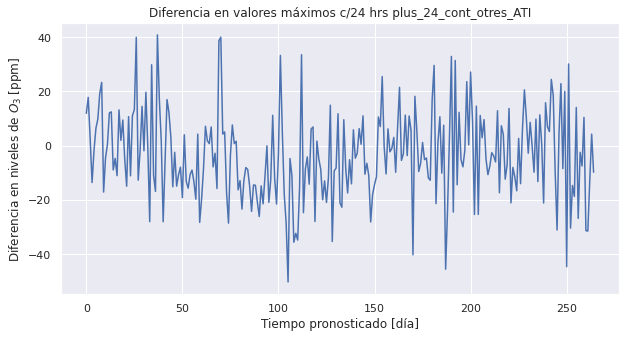

plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.5983590592851153
Desviación estándar de diferencia en valores máximos diarios: 18.160769440360454


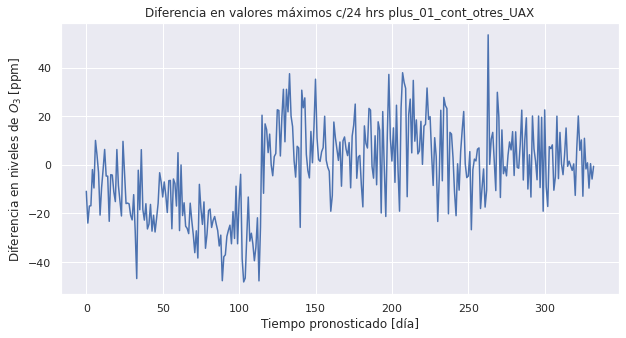

plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -2.944819872964642
Desviación estándar de diferencia en valores máximos diarios: 22.235302268412944


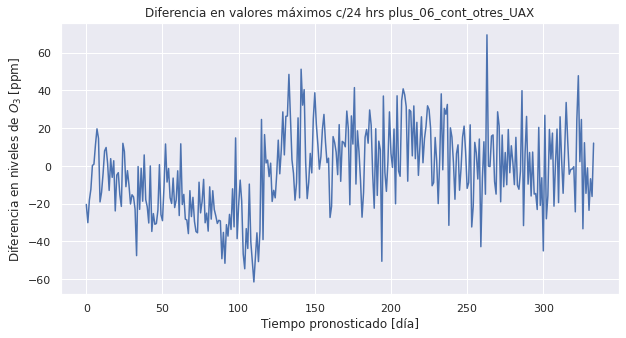

plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.3117428393591017
Desviación estándar de diferencia en valores máximos diarios: 21.452149862477473


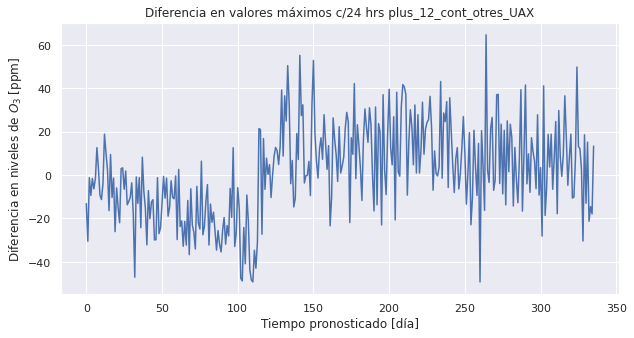

plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -0.42040453186954363
Desviación estándar de diferencia en valores máximos diarios: 21.323003802491982


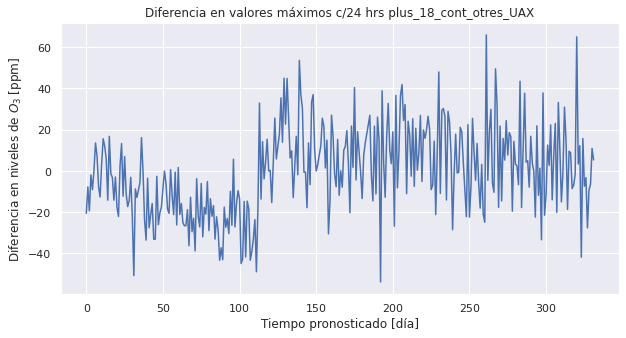

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 0.9515719903559843
Desviación estándar de diferencia en valores máximos diarios: 22.76848230452815


Promedio de h24_max_err_mean: 5.061320931160385
Promedio de h24_max_err_std: 17.861924834172537


In [33]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío
# TODO, poner opcion para bloquear el graficado.
results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [34]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 4.998422144227109
Maximum error std dev over 24 hrs: 12.42738826684824
Mean error mean over 24 hrs: 0.596750082707001
Mean error std dev over 24 hrs: 4.389974561507988
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 17.586409340077395
Maximum error std dev over 24 hrs: 18.23452213721007
Mean error mean over 24 hrs: 0.9374238187011734
Mean error std dev over 24 hrs: 6.171589247891838
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: -5.129151033632683
Maximum error std dev over 24 hrs: 11.109957142069682
Mean error mean over 24 hrs: -3.441873440838824
Mean error std dev over 24 hrs: 3.4410890561963345
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: 2.37944405635427
Maximum error std dev over 24 hrs: 16.107889898101625
Mean error mean over 24 hrs: 1.9094459018835535
Mean error std dev over 24 hrs: 5.1410317375349885
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: -2.791813711632885
Maximum error std dev over

plus_04_cont_otres_CUT
Maximum error mean over 24 hrs: 9.193024011239114
Maximum error std dev over 24 hrs: 14.889443469611333
Mean error mean over 24 hrs: -0.3921328962018065
Mean error std dev over 24 hrs: 4.240699017693821
plus_04_cont_otres_PED
Maximum error mean over 24 hrs: 2.610255216370519
Maximum error std dev over 24 hrs: 17.451053453539345
Mean error mean over 24 hrs: 2.1076755301250314
Mean error std dev over 24 hrs: 4.797689997135615
plus_04_cont_otres_TAH
Maximum error mean over 24 hrs: 14.46897483890892
Maximum error std dev over 24 hrs: 17.17511191387661
Mean error mean over 24 hrs: 2.5436456185347223
Mean error std dev over 24 hrs: 5.066539024156738
plus_04_cont_otres_GAM
Maximum error mean over 24 hrs: 11.100004923826008
Maximum error std dev over 24 hrs: 16.80890151486003
Mean error mean over 24 hrs: 0.40521183759261153
Mean error std dev over 24 hrs: 5.571039012360091
plus_04_cont_otres_IZT
Maximum error mean over 24 hrs: 0.750023604786329
Maximum error std dev over

Mean error mean over 24 hrs: 1.5257857064016511
Mean error std dev over 24 hrs: 7.372100093236733
plus_07_cont_otres_FAC
Maximum error mean over 24 hrs: 4.924994344414125
Maximum error std dev over 24 hrs: 17.36004978316228
Mean error mean over 24 hrs: 1.4748551360383362
Mean error std dev over 24 hrs: 5.461700904193056
plus_07_cont_otres_TLA
Maximum error mean over 24 hrs: 2.776166162921884
Maximum error std dev over 24 hrs: 14.902943053041895
Mean error mean over 24 hrs: 0.5003546173991231
Mean error std dev over 24 hrs: 4.523060150434793
plus_07_cont_otres_MER
Maximum error mean over 24 hrs: 2.727118357426703
Maximum error std dev over 24 hrs: 17.699115804804176
Mean error mean over 24 hrs: 2.0669536957633023
Mean error std dev over 24 hrs: 5.513554868775705
plus_07_cont_otres_XAL
Maximum error mean over 24 hrs: 3.242372410733935
Maximum error std dev over 24 hrs: 14.937544631982286
Mean error mean over 24 hrs: 0.5577312431424994
Mean error std dev over 24 hrs: 5.071766182382488
plu

plus_10_cont_otres_AJM
Maximum error mean over 24 hrs: 0.9405432472452085
Maximum error std dev over 24 hrs: 18.022485355380184
Mean error mean over 24 hrs: -3.5409472605638337
Mean error std dev over 24 hrs: 7.164817738122356
plus_10_cont_otres_VIF
Maximum error mean over 24 hrs: 8.55581498997552
Maximum error std dev over 24 hrs: 16.45489088072441
Mean error mean over 24 hrs: 0.5072837573076999
Mean error std dev over 24 hrs: 5.877948461834228
plus_11_cont_otres_UIZ
Maximum error mean over 24 hrs: 7.187650770148975
Maximum error std dev over 24 hrs: 16.10479692518396
Mean error mean over 24 hrs: 0.3261206663428269
Mean error std dev over 24 hrs: 5.963271442506146
plus_11_cont_otres_AJU
Maximum error mean over 24 hrs: 19.279399328102354
Maximum error std dev over 24 hrs: 19.095288355356306
Mean error mean over 24 hrs: 0.9162599626889237
Mean error std dev over 24 hrs: 7.086759662637047
plus_11_cont_otres_ATI
Maximum error mean over 24 hrs: -4.1730594993533945
Maximum error std dev ove

Maximum error std dev over 24 hrs: 15.96988175786843
Mean error mean over 24 hrs: 0.288115247374489
Mean error std dev over 24 hrs: 5.9811475911732375
plus_14_cont_otres_UIZ
Maximum error mean over 24 hrs: 7.8797892116060195
Maximum error std dev over 24 hrs: 15.850282138511966
Mean error mean over 24 hrs: 0.6043429005332706
Mean error std dev over 24 hrs: 5.727191376444371
plus_14_cont_otres_AJU
Maximum error mean over 24 hrs: 22.45555100937235
Maximum error std dev over 24 hrs: 18.236993085473035
Mean error mean over 24 hrs: 1.0707658968000573
Mean error std dev over 24 hrs: 6.571271143180245
plus_14_cont_otres_ATI
Maximum error mean over 24 hrs: -2.0536546133514633
Maximum error std dev over 24 hrs: 14.37914668370891
Mean error mean over 24 hrs: -4.244771761404243
Mean error std dev over 24 hrs: 5.060969497301123
plus_14_cont_otres_CUA
Maximum error mean over 24 hrs: 6.7383323931762344
Maximum error std dev over 24 hrs: 20.00820838735003
Mean error mean over 24 hrs: 2.05007766789215

plus_16_cont_otres_TLA
Maximum error mean over 24 hrs: 4.097703210423502
Maximum error std dev over 24 hrs: 14.273901513070768
Mean error mean over 24 hrs: 0.1676879221580447
Mean error std dev over 24 hrs: 4.6537893927361225
plus_16_cont_otres_MER
Maximum error mean over 24 hrs: 3.250636132915368
Maximum error std dev over 24 hrs: 16.039603027799505
Mean error mean over 24 hrs: 1.275185815627209
Mean error std dev over 24 hrs: 5.411744220717021
plus_16_cont_otres_XAL
Maximum error mean over 24 hrs: 2.8359356567639264
Maximum error std dev over 24 hrs: 14.479856523484425
Mean error mean over 24 hrs: -0.2701637980873402
Mean error std dev over 24 hrs: 5.255072755800963
plus_16_cont_otres_LLA
Maximum error mean over 24 hrs: 2.980783970430282
Maximum error std dev over 24 hrs: 13.629159713424588
Mean error mean over 24 hrs: 0.4063171761794625
Mean error std dev over 24 hrs: 4.4231882573377534
plus_16_cont_otres_TLI
Maximum error mean over 24 hrs: 10.862789944904607
Maximum error std dev o

plus_18_cont_otres_INN
Maximum error mean over 24 hrs: 9.379622399390161
Maximum error std dev over 24 hrs: 17.974903482024562
Mean error mean over 24 hrs: -1.6173276867899862
Mean error std dev over 24 hrs: 7.303945228079925
plus_18_cont_otres_AJM
Maximum error mean over 24 hrs: 1.8451666525232862
Maximum error std dev over 24 hrs: 17.432725018040465
Mean error mean over 24 hrs: -4.034091809107314
Mean error std dev over 24 hrs: 7.0954089992084395
plus_18_cont_otres_VIF
Maximum error mean over 24 hrs: 7.817987127932246
Maximum error std dev over 24 hrs: 14.95020943829575
Mean error mean over 24 hrs: 0.11357897603345223
Mean error std dev over 24 hrs: 5.247182863089143
plus_19_cont_otres_UIZ
Maximum error mean over 24 hrs: 4.688681696229062
Maximum error std dev over 24 hrs: 17.331778271346437
Mean error mean over 24 hrs: -0.09169275989640224
Mean error std dev over 24 hrs: 6.010160921415226
plus_19_cont_otres_AJU
Maximum error mean over 24 hrs: 18.96249008178711
Maximum error std dev 

plus_21_cont_otres_FAC
Maximum error mean over 24 hrs: 3.31448007503026
Maximum error std dev over 24 hrs: 17.21089250974325
Mean error mean over 24 hrs: 0.40879229435898323
Mean error std dev over 24 hrs: 5.682220561729458
plus_21_cont_otres_TLA
Maximum error mean over 24 hrs: 2.0682953753941495
Maximum error std dev over 24 hrs: 15.159838681782997
Mean error mean over 24 hrs: -0.23120640449120972
Mean error std dev over 24 hrs: 4.664182700345612
plus_21_cont_otres_MER
Maximum error mean over 24 hrs: 0.2803001927657866
Maximum error std dev over 24 hrs: 18.156403819651974
Mean error mean over 24 hrs: 0.7979518587600459
Mean error std dev over 24 hrs: 5.841140087703404
plus_21_cont_otres_XAL
Maximum error mean over 24 hrs: 1.697171864884623
Maximum error std dev over 24 hrs: 15.32452942179959
Mean error mean over 24 hrs: -0.7456580349122095
Mean error std dev over 24 hrs: 5.464857208902904
plus_21_cont_otres_LLA
Maximum error mean over 24 hrs: 3.448468328203474
Maximum error std dev ov

Mean error mean over 24 hrs: -0.6828594625740528
Mean error std dev over 24 hrs: 8.144246431170073
plus_23_cont_otres_MON
Maximum error mean over 24 hrs: 6.3572117069789345
Maximum error std dev over 24 hrs: 15.162082064832456
Mean error mean over 24 hrs: -1.0220716998122987
Mean error std dev over 24 hrs: 5.7336556226814634
plus_23_cont_otres_NEZ
Maximum error mean over 24 hrs: 12.002650784100858
Maximum error std dev over 24 hrs: 18.1716424269354
Mean error mean over 24 hrs: 2.2189663259026395
Mean error std dev over 24 hrs: 6.180228496003075
plus_23_cont_otres_INN
Maximum error mean over 24 hrs: 7.656423842156683
Maximum error std dev over 24 hrs: 18.58331573734127
Mean error mean over 24 hrs: -1.5870635241339537
Mean error std dev over 24 hrs: 7.544760418209222
plus_23_cont_otres_AJM
Maximum error mean over 24 hrs: 1.0054250924118802
Maximum error std dev over 24 hrs: 18.798598533070418
Mean error mean over 24 hrs: -4.055485723829689
Mean error std dev over 24 hrs: 7.35575964789888

## <a id="Scatter_Plots_of_24h_Error_Graphics">Scatter Plots of 24h Error Eval</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

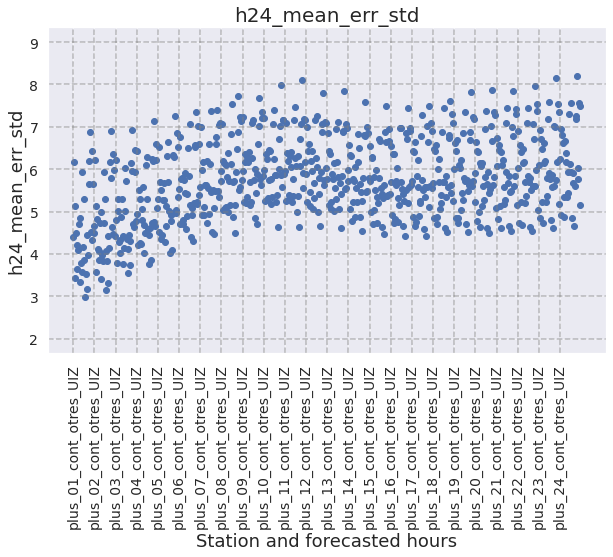

In [35]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

## <a id="Bar_Charts_of_24h_Errors_over_Stations">Bar Charts of 24h Errors over Stations</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

Per station h24_max_err_mean: 5.2093


Per station h24_max_err_std: 16.9803


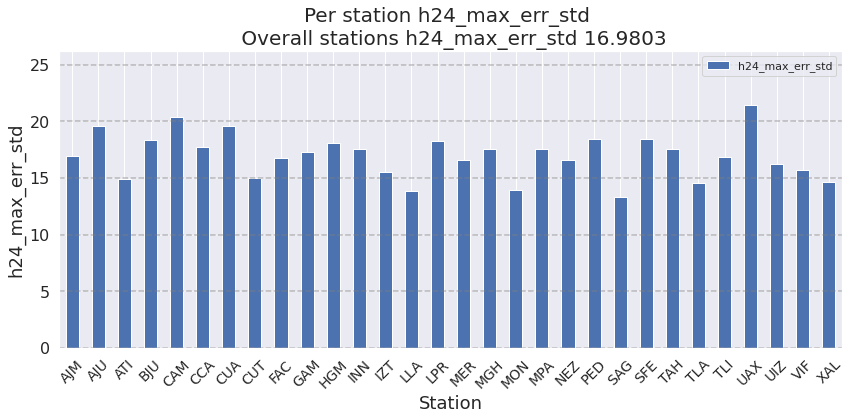

Per station h24_mean_err_mean: -0.4149


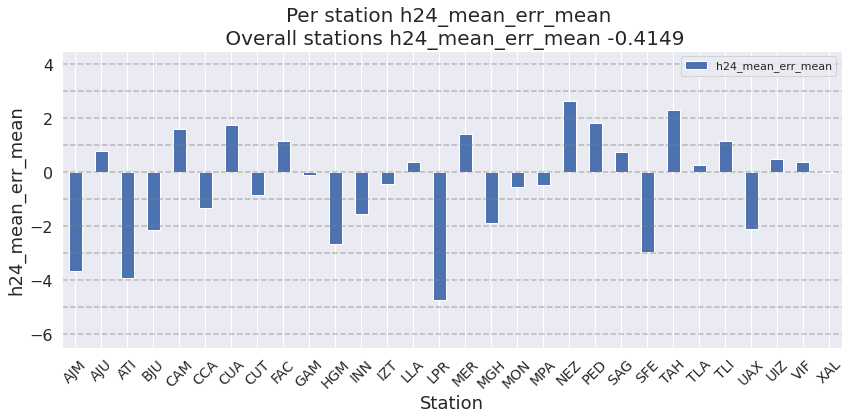

Per station h24_mean_err_std: 5.7490


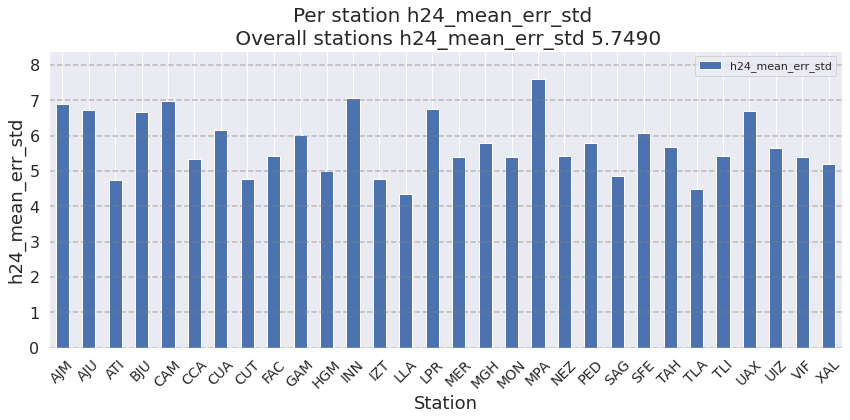

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

## <a id="Results_df_Table">Results_df Table</a>
- [Return to Plots Index](#Plots_index)  

In [37]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.936156   7.118227  2.976779e+14   
1    plus_01_cont_otres_AJU           0.893209  11.612323  2.873532e+14   
2    plus_01_cont_otres_ATI           0.928181   7.391601  1.003184e+15   
3    plus_01_cont_otres_CUA           0.883675   8.394414  3.908166e-01   
4    plus_01_cont_otres_SFE           0.904346   8.120199  1.434481e+14   
..                      ...                ...        ...           ...   
715  plus_24_cont_otres_MON           0.890021   9.995342  6.066160e+12   
716  plus_24_cont_otres_NEZ           0.886378  10.266807  9.246081e+12   
717  plus_24_cont_otres_INN           0.778344  10.772329  4.597497e-01   
718  plus_24_cont_otres_AJM           0.811592  11.239305  6.257708e-01   
719  plus_24_cont_otres_VIF           0.875941   8.352417  6.331904e-01   

            MSE       RMSE        R2  Index of agreement  h24_max_err_mean  \
0     89.398051   9.455054  0.868104            0.960310          4.998422   
1    222.984055  14.932651  0.673850            0.857260         17.586409   
2     91.249598   9.552466  0.828155            0.956939         -5.129151   
3    120.091363  10.958620  0.771604            0.935130          2.379444   
4    111.815082  10.574265  0.799840            0.945033         -2.791814   
..          ...        ...       ...                 ...               ...   
715  153.231393  12.378667  0.778858            0.926966          6.796548   
716  186.022384  13.639002  0.754519            0.916757         12.628558   
717  179.691898  13.404921  0.575893            0.827604          7.299442   
718  205.260524  14.326916  0.630920            0.878210          2.161263   
719  117.888613  10.857652  0.761329            0.922356          8.060739   

     h24_max_err_std  h24_mean_err_mean  h24_mean_err_std  
0          12.427388           0.596750          4.389975  
1          18.234522           0.937424          6.171589  
2          11.109957          -3.441873          3.441089  
3          16.107890           1.909446          5.141032  
4          14.350823          -2.861705          4.496205  
..               ...                ...               ...  
715        15.418748          -0.750911          5.772188  
716        18.198695           2.956183          6.030788  
717        18.688914          -1.569142          7.557477  
718        19.051209          -3.600168          7.490638  
719        15.532001           0.419087          5.142281  

[720 rows x 12 columns]

In [38]:
# saving results_df table into a csv file
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)

## <a id="Histogram_Fit">Histogram Fit</a>
- [Return to Plots Index](#Plots_index)  

In [39]:
# Case for overall h24_max_err of the model

overall_errors = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['max_y_true']
    max_y_pred = values['max_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors.append(error)


# Convert to numpy array for easier statistical analysis
overall_errors = np.array(overall_errors)

# Fit a normal distribution to the errors data
mu, std = norm.fit(overall_errors)

# Create a histogram of the errors
plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors MaxVal 24h")

# Create a PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
overall_errors2 = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['mean_y_true']
    max_y_pred = values['mean_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:
        if error != 0:
            overall_errors2.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors2 = np.array(overall_errors2)
plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors Mean 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)


plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")

plt.xlabel("Errors")
plt.ylabel("Probability")
plt.title("Fitted Normal Distribution to Errors")
plt.legend()
plt.show()

#mean_np, std_np, mu, std

## <a id="Overall_Results_Table">Overall Results Table</a>
- [Return to Plots Index](#Plots_index)  

In [40]:
# Overall values of results for the model
overall = results_df.mean()
print(overall)


Correlation Index     8.809097e-01
MAE                   9.540290e+00
MAPE                  1.647712e+14
MSE                   1.600283e+02
RMSE                  1.256765e+01
R2                    7.567871e-01
Index of agreement    9.223043e-01
h24_max_err_mean      5.209274e+00
h24_max_err_std       1.698025e+01
h24_mean_err_mean    -4.149484e-01
h24_mean_err_std      5.749001e+00
dtype: float64
